# people_主題分析
* 主題分析是以降維文的方式，萃取文章的主題。每篇文章均由不同主題，依不同比例或投影量所構成。
* 降維的方法，有三個選項：
* 1 方法一 SVD
* 2 方法二 LDA
* 3 方法三 NMF,Non-negative Matrix Factorization
* 觀察不同主題的逐年變化

# 函數 topic model()
* method 有 svd,lda, nmf(Non-negative Matrix Factorization) 三個選項
* doc_list 斷詞後之本文 list of string 各詞之間空白隔開
* num_i 主題數目
* year 各年度的 list
* topics 各主題的命名

## (df_topic, df, df_lsa)=topic_model_year(path, df, field,num_i, method,title)

In [1]:
def topic_model_year(path, df, field,num_i, method,title):
    # from __future__ import print_function
    import sklearn
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import NMF
    from sklearn.decomposition import LatentDirichletAllocation
    from sklearn.decomposition import TruncatedSVD
    from sklearn.preprocessing import Normalizer
    from sklearn import metrics
    from sklearn.cluster import KMeans, MiniBatchKMeans
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import io
    import re
    import random
    import matplotlib
    
    # 直接繪圖，毋須 plot.show()
    %matplotlib inline  
    # 中文設定1: 楷體字
    from matplotlib import rcParams
    rcParams["font.sans-serif"] = ["kaiu"] 
    rcParams["font.family"] ="DFKai-sb"
    
    doc_list=df[field]
    
    # 文章字詞矩陣
    ngram=(1,1)
    vectorizer = TfidfVectorizer(min_df = 1,ngram_range= ngram)
    dtm_tfidf = vectorizer.fit_transform(doc_list) # sparse matrix
    # 字詞的編號
    terms=vectorizer.vocabulary_
    # 字詞的 list
    term_list=vectorizer.get_feature_names_out()
    if method=="svd":
        lsa = TruncatedSVD(num_i, algorithm = 'arpack')   # object
    elif method=="lda":
        lsa=LatentDirichletAllocation(num_i)
    elif method=="nmf":    
        lsa= NMF(num_i)   # 各投影值只有正值，沒有負值    

    dtm_lsa = lsa.fit_transform(dtm_tfidf)  # 加權
    dtm_com = lsa.fit(dtm_tfidf)  # object, not numpy array

    # components
    comp=dtm_com.components_
    print("維度數",len(comp))
    print("字詞數",len(comp[0]))

    # 每個維度軸都是各字詞的線性組合，每個維度的構成
    df_concept=pd.DataFrame(comp,columns= term_list)
    df_concept=df_concept.transpose()

    # 各維度字詞，依重要性大小排序
    con=[]
    sig=[]
    for n in range(len(df_concept.columns)):
        # 由大至小排序
        df_order= df_concept.sort_values(by=n, ascending=False)
        con.append(list(df_order.index)[0:500])
        sig.append(list(df_order[n])[0:500])

    # 印出各軸的重要字詞
    for n in range(len(con)):
        print (n,con[n][:30])          

    # 轉成 dataframe 格式
    df_topic=pd.DataFrame(con).T
    # 依投影量最大的主題歸類
    cate=[]
    for n in range(len(dtm_lsa)):
        ma=max(dtm_lsa[n])
        po=list(dtm_lsa[n]).index(ma)
        cate.append(po)
    df['cate']=cate

    columns=[]
    for n in range(num_i):
        columns.append("topic"+str(n))
    df_lsa=pd.DataFrame(dtm_lsa,columns=columns)
    df_lsa["year"]=df.year
    
    title=title+field+"_"+method+"_"+str(num_i)+'_topics by year'
    # save，必須要有 working 次目錄  -------------------------------   
    fname=path+"working/"+title+"_df_topics.xlsx"
    writer = pd.ExcelWriter(fname)
    df_topic.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()  

    fname=path+"working/"+title+"_df.xlsx"
    writer = pd.ExcelWriter(fname)
    df.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()    
    
    fname=path+"working/"+title+"_df_lsa.xlsx"
    writer = pd.ExcelWriter(fname)
    df_lsa.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()     
    
    return df_topic, df, df_lsa

## (df_ts, totals,size)=plot_topic_model_year(path, df_lsa,topics, num_i,title)

In [84]:
def plot_topic_model_year(path, df_lsa,topics, num_i,title):    
    # 主題佔比赹勢圖，自行調整類別數
    # 欄位名稱
    columns=[]
    for n in range(num_i):
        columns.append("topic"+str(n)) 
        
    year=df.year.unique()    
        
    # 各年各軸投影量加總    
    totals=[]
    for y in range(len(year)):
        total=0
        for n in range(num_i):
            df_tem=df_lsa[df_lsa["year"]==year[y]]
            total+=df_tem[columns[n]].sum()            
        totals.append(total)

    # 計算各軸投影百分比    
    ts=[]    
    for n in range(num_i):    
        t=[]
        for y in range(len(year)):    
            df_tem=df_lsa[df_lsa["year"]==year[y]]
            t.append(df_tem[columns[n]].sum()/totals[y])
        ts.append(t)    
        
    import matplotlib.pyplot as plt 
    # 中文設定
    from matplotlib import rcParams
    rcParams["font.sans-serif"] = ["kaiu"] 
    rcParams["font.family"] ="DFKai-sb"
    # 折線圖 -------------------------------------  
    fig, ax = plt.subplots(figsize=(25,13))
    x=year
    for c in range(num_i): 
        ax.plot(x, ts[c], label=topics[c])
    
    # 設定顏色，圖例，線的型態，標記 
    ax.legend(loc=1);  
    ax.set_xlabel('year')     # X label
    ax.set_xticks([1950,1960,1970,1980,2000])
    ax.set_ylabel('freq.')    # y lobel
    # 標題
    ax.set_title(title+'折線圖');   # title
    plt.show()    

    #疊加圖 ------------------------------------------
    ts_min=min(min(ts))
    # 如果 ts 有負值，整個提昇，使均為正值 
    if ts_min<0:
        import numpy as np
        ts=list(np.array(ts)+abs(ts_min))
    
    # 圖區大小
    plt.figure(figsize=(25,13))  
    # 繪疊加圖
    if num_i==2:
        plt.stackplot(year, ts[0],ts[1], labels=topics)
    elif num_i==3:
        plt.stackplot(year, ts[0],ts[1],ts[2], labels=topics)
    elif num_i==4:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3], labels=topics)        
    elif num_i==5:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4], labels=topics)         
    elif num_i==6:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5], labels=topics)           
    elif num_i==7:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6], labels=topics)         
    elif num_i==8:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],labels=topics)          
    elif num_i==9:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],ts[8],labels=topics)  
    elif num_i==10:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],ts[8],ts[9],labels=topics) 
    # X 軸尺度
    # plt.xticks(year)
    # X 軸標題
    plt.xlabel('year')   
    # Y 軸標題律
    plt.ylabel('value')   
    # 圖例
    plt.legend() 
    # 標題
    plt.title(title+'疊加圖')    
    plt.show()
    
    # 圓餅圖 -----------------------------------------------------
    df_trend=pd.DataFrame(ts,columns=year)
    size=[]
    for n in range(num_i):
        total=df_trend.iloc[n].sum()
        size.append(total)

    plt.figure(figsize=(10,10))
    # 圖餅圖 pie，變數值，標籤，數字格式，加陰影，旋轉角度
    plt.pie(size, labels=topics, autopct='%1.1f%%', shadow=True, startangle=100) 
    # 正圓形
    plt.axis('equal')  
    plt.show()    

    # 長條圖 --------------------------------------------------------
    plt.figure(figsize=(10,5))
    plt.bar(topics,size) 
    plt.show()
    
    df_ts=pd.DataFrame(ts,columns=year)
    title=field+" "+method+" "+method+" "+str(num_i)+' topics by year'
    # save，必須要有 working 次目錄  -------------------------------   
    fname=path+"working/"+title+"_df_ts.xlsx"
    writer = pd.ExcelWriter(fname)
    df_ts.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()  
    
    return df_ts, totals,size

# 讀取檔案 tfidf 關鍵字

In [11]:
# 讀取檔案 #######################################
import pandas as pd
# 必須要有的參數
unit="arti"
field="tfidf"
path="D:/my python/people/" 
title="all"
fname=path+"working/"+unit+"_"+field+"_"+title+".pkl"
df=pd.read_pickle(fname)

# 範例一：nmf 主題分析

In [14]:
method="nmf"  # svd,lda, nmf 三選一
path="D:/my python/people/" 
num_i=10
field="tfidf"
title=""
(df_topic, df, df_lsa)=topic_model_year(path, df, field,num_i, method,title)

C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


維度數 10
字詞數 1967779
0 ['合作', '关系', '两国', '发展', '会见', '中国', '友好合作', '两国关系', '领域', '经济', '两国人民', '交流', '中方', '友好', '友谊', '建交', '访问', '国际', '稳定', '共同努力', '友好关系', '中国政府', '增进', '领导人', '交往', '双边关系', '总理', '互利', '总统', '赞赏']
1 ['生产', '农业', '农民', '计划', '提高', '技术', '干部', '粮食', '增产', '农村', '组织', '工人', '产量', '社员', '职工', '工厂', '群众', '领导', '保证', '公社', '办法', '地区', '解决', '经验', '万亩', '供应', '工业', '平均', '推广', '劳动']
2 ['斗争', '反对', '美帝国主义', '侵略', '帝国主义', '胜利', '民族', '全世界', '越南', '团结', '战争', '独立', '和平', '支持', '阴谋', '世界和平', '保卫', '谴责', '解放', '民主', '侵略者', '力量', '正义斗争', '战斗', '走狗', '敌人', '世界', '美国', '爱好和平', '朝鲜']
3 ['毛主席', '革命', '无产阶级', '毛泽东思想', '修正主义', '教导', '文化大革命', '阶级斗争', '学习', '资产阶级', '思想', '路线', '革命路线', '无产阶级专政', '伟大领袖', '批判', '群众', '同志', '斗争', '反革命', '刘少奇', '胜利', '贫下中农', '阶级敌人', '活学活用', '著作', '阶级', '大批判', '促生产', '干部']
4 ['代表团', '北京', '访问', '率领', '团长', '中国', '乘飞机', '大使', '机场', '邀请', '前往', '到达', '离开', '会见', '今天下午', '友好', '友好访问', '负责人', '一行', '谈话', '夫人', '回国', '今天上午', '出席', '参观', '部长', '送行', '亲切友好', '宴会', 

In [15]:

df_topic.iloc[:20]

,0,1,2,3,4,5,6,7,8,9
0,合作,生产,斗争,毛主席,代表团,比赛,建设,美国,传真照片,企业
1,关系,农业,反对,革命,北京,选手,社会,总统,附图片,10
2,两国,农民,美帝国主义,无产阶级,访问,中国,领导,会议,图为,经济
3,发展,计划,侵略,毛泽东思想,率领,冠军,发展,宣布,杜修贤,市场
4,会见,提高,帝国主义,修正主义,团长,女子,教育,国家,美联社,发展
5,中国,技术,胜利,教导,中国,运动员,思想,联合国,照片,投资
6,友好合作,干部,民族,文化大革命,乘飞机,锦标赛,精神,政府,通讯社,增长
7,两国关系,粮食,全世界,阶级斗争,大使,北京,同志,谈判,徐步,公司
8,领域,增产,越南,学习,机场,男子,群众,苏联,东京,北京
9,经济,农村,团结,资产阶级,邀请,决赛,科学,国际,吕全成,管理


## 各主題命名

In [16]:
# 各主題命名，自行校訂
topics=list(range(num_i))
topics[0]="國際合作"
topics[1]="農業生產"
topics[2]="世界革命"
topics[3]="階級革命"
topics[4]="友好訪問"
topics[5]="運動比賽"
topics[6]="精神建設"
topics[7]="國際情勢"
topics[8]="產業發展"
topics[9]="圖文報導"

## 趨勢變化

C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


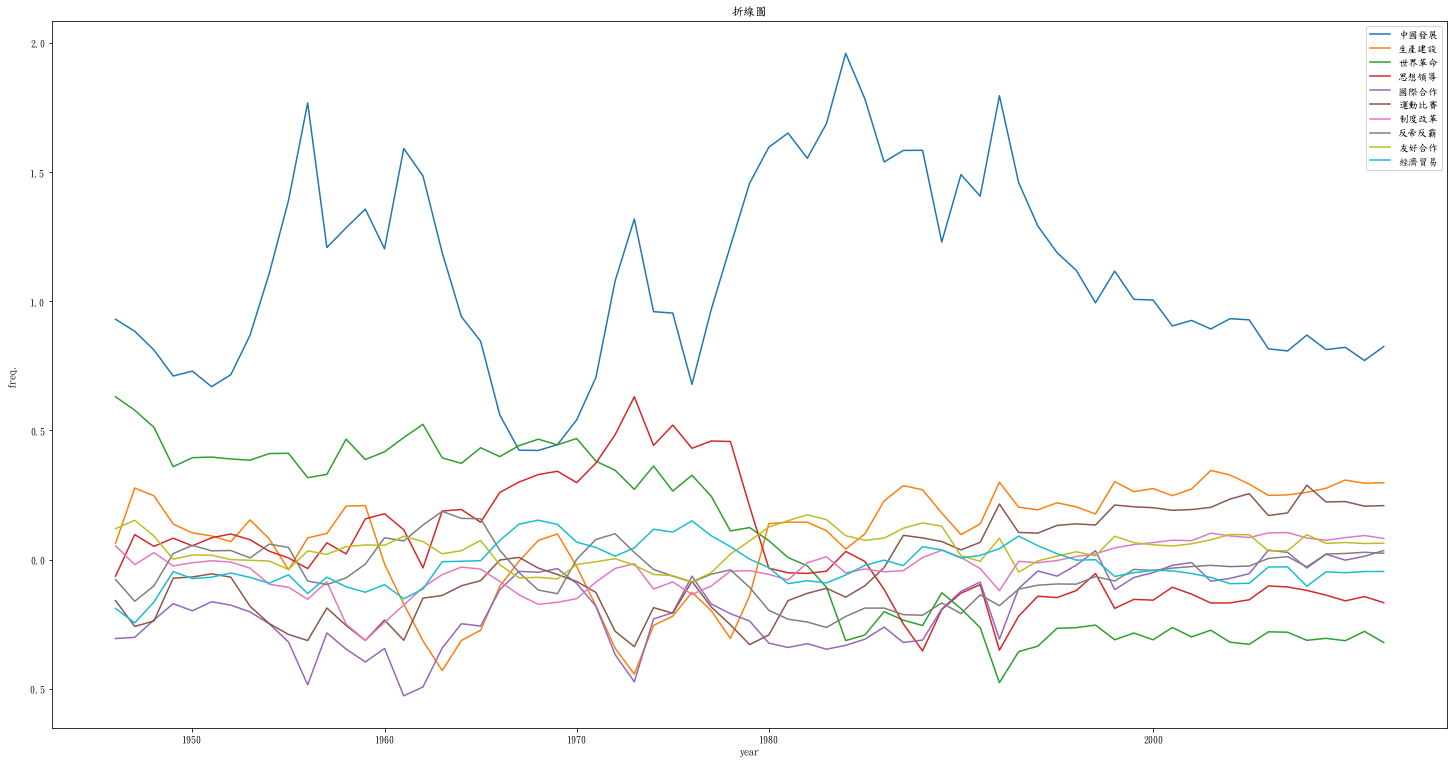

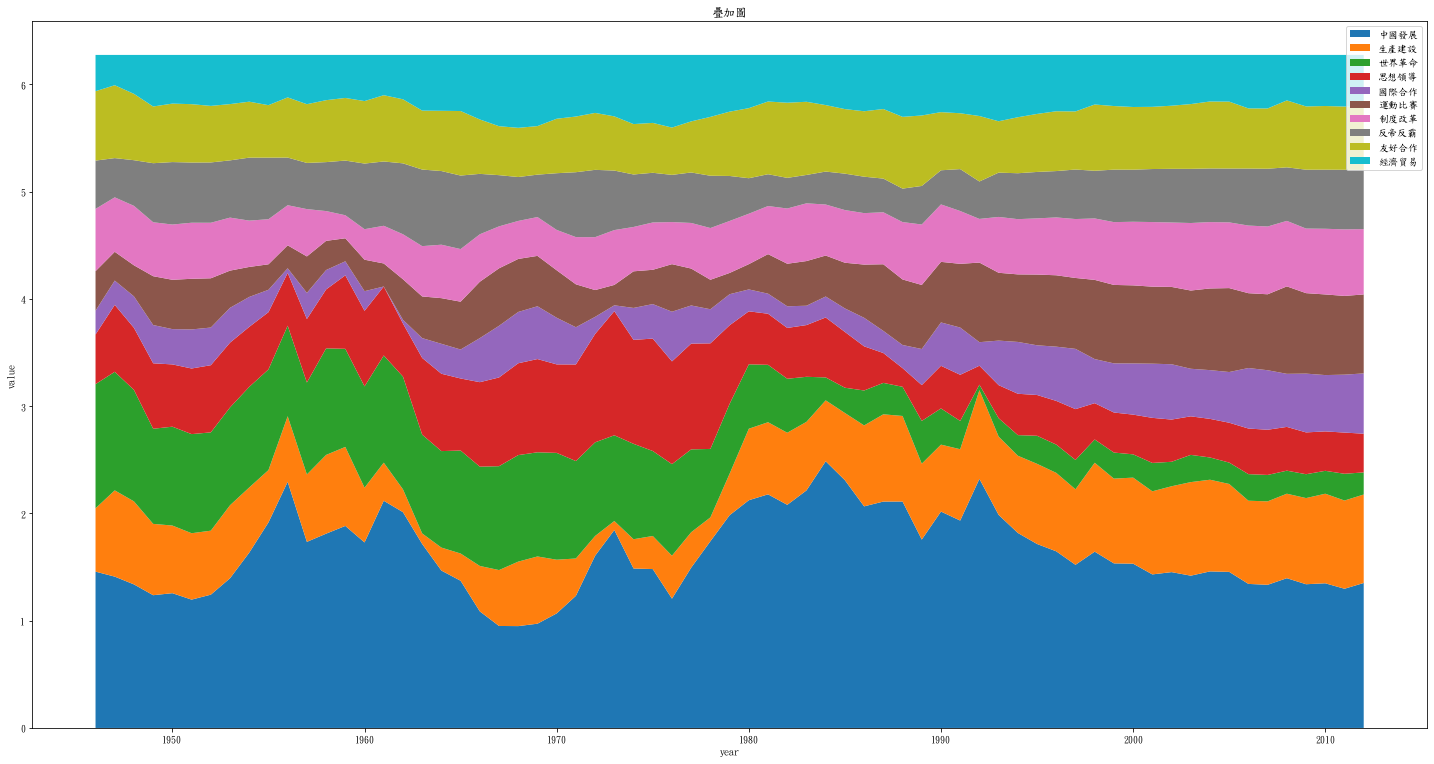

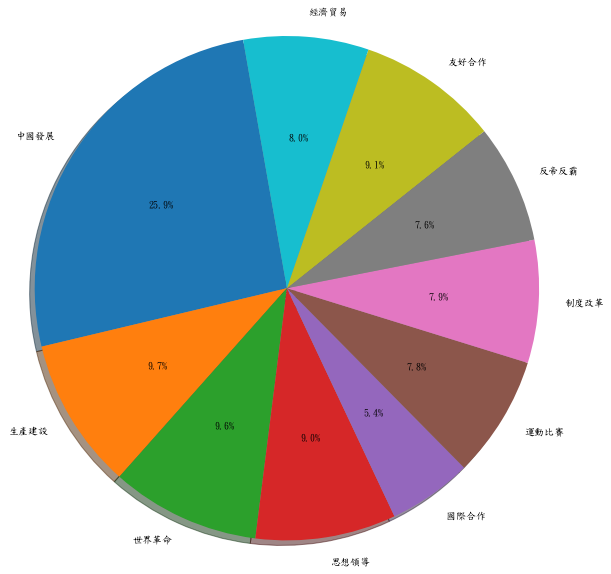

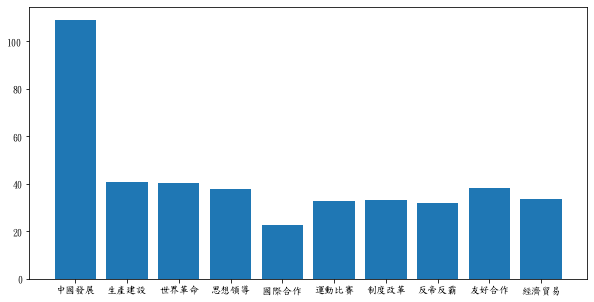

In [85]:
topic=""
(df_ts, totals,size)=plot_topic_model_year(path, df_lsa,topics, num_i,title)

# 範例二：lda主題分析

In [133]:
method="lda"  # svd,lda, nmf 三選一
path="D:/my python/people/" 
num_i=10
field="tfidf"
title=""
(df_topic, df, df_lsa)=topic_model_year(path, df, field,num_i, method,title)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


維度數 10
字詞數 1969274
0 ['美国', '亿美元', '治疗', '经济', '医院', '美元', '患者', '国家', '10', '出口', '减少', '市场', '银行', '案件', '增长', '公司', '进口', '疾病', '调查', '宣布', '病人', '价格', '犯罪', '世界', '政府', '12', '货币', '措施', '研究', '医生']
1 ['孩子', '生活', '地说', '艺术', '观众', '附图片', '文化', '生命', '老人', '来到', '故事', '精神', '祖国', '历史', '作品', '演出', '创作', '表演', '形象', '同志', '时代', '战士', '母亲', '电影', '青年', '朋友', '演员', '人物', '传统', '中国']
2 ['企业', '10', '发展', '生产', '公司', '北京', '全国', '产品', '市场', '技术', '工程', '建设', '国家', '项目', '投资', '20', '部门', '服务', '开发', '12', '管理', '增长', '30', '经济', '农民', '地区', '资金', '提高', '城市', '100']
3 ['照片', '飞机', '袭击', '一架', '地区', '受伤', '打死', '部队', '死亡', '美联社', '美国', '战斗', '发射', '缴获', '敌人', '公里', '击落', '士兵', '打伤', '南部', '飞行', '据点', '游击队', '北部', '爆炸', '一名', '一艘', '进攻', '电视', '歼灭']
4 ['学生', '同志', '学习', '学校', '教育', '部队', '全国', '传真照片', '领导', '北京', '教师', '培养', '建设', '祖国', '革命', '青年', '中国共产党', '事业', '教学', '组织', '纪念', '贡献', '精神', '出席', '大学', '周年', '小学', '新中国', '举办', '北京市']
5 ['发展', '社会', '建设', '改革', '领导', '制度', '经济', '群众', '干部

In [134]:
df_topic=res[0]
df_topic.iloc[:20]

,0,1,2,3,4,5,6,7,8,9
0,美国,孩子,企业,照片,学生,发展,中国,生产,比赛,美国
1,亿美元,生活,10,飞机,同志,社会,会见,群众,中国,反对
2,治疗,地说,发展,袭击,学习,建设,代表团,干部,选手,国家
3,经济,艺术,生产,一架,学校,改革,访问,毛主席,运动员,和平
4,医院,观众,公司,地区,教育,领导,北京,工人,冠军,政府
5,美元,附图片,北京,受伤,部队,制度,合作,领导,北京,苏联
6,患者,文化,全国,打死,全国,经济,友好,社员,女子,斗争
7,国家,生命,产品,部队,传真照片,群众,大使,革命,出版,总统
8,10,老人,市场,死亡,领导,干部,两国,农民,锦标赛,会议
9,出口,来到,技术,美联社,北京,提高,发展,提高,决赛,支持


## 各主題命名

In [135]:
# 各主題命名，自行校訂
topics=list(range(num_i))
topics[0]="國際合作"
topics[1]="農業生產"
topics[2]="世界革命"
topics[3]="階級革命"
topics[4]="友好訪問"
topics[5]="運動比賽"
topics[6]="精神建設"
topics[7]="國際情勢"
topics[8]="產業發展"
topics[9]="圖文報導"

## 趨勢變化

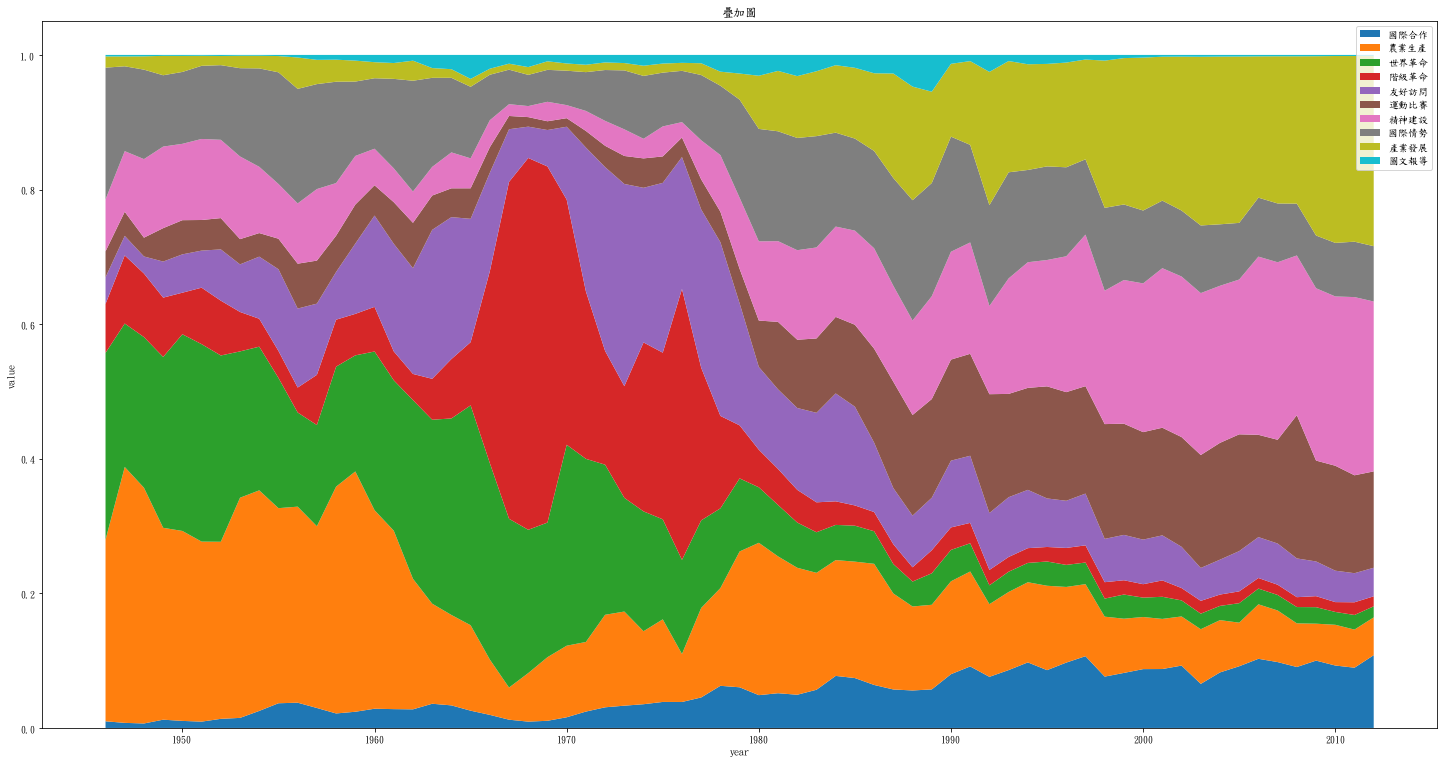

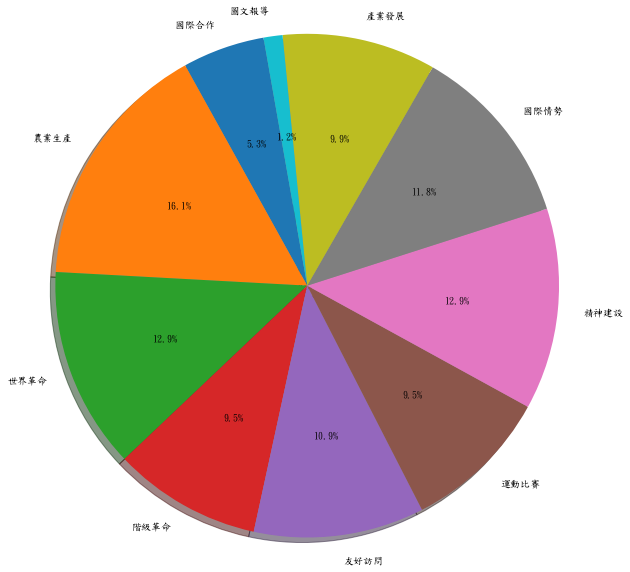

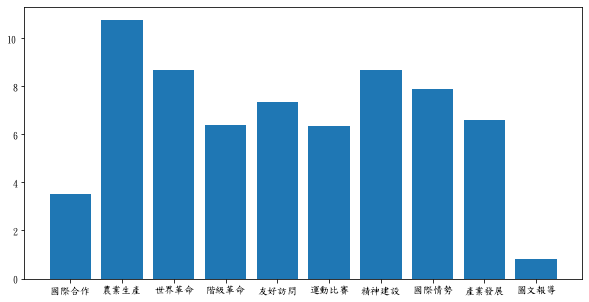

In [132]:
topic=""
(df_ts, totals,size)=plot_topic_model_year(path, df_lsa,topics, num_i,title)

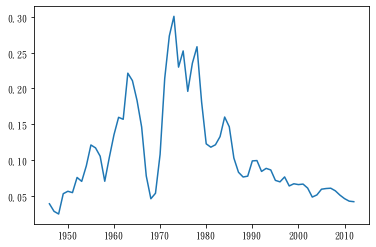

In [111]:
plt.plot(year, trend.iloc[4])
plt.show()

[3.535525173364487, 10.774226885291469, 8.673041956095371, 6.3725503635080685, 7.333037103059443, 6.345535494158992, 8.666043007802367, 7.876041800333307, 6.609983440194399, 0.8140147761920996]


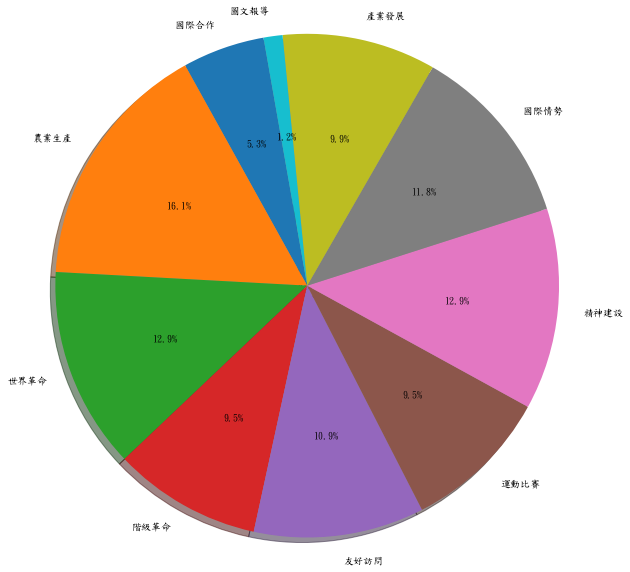

In [127]:
size=plot_topic_model_pei(trend, topics)

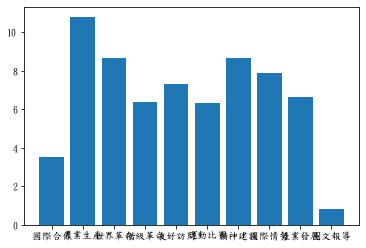

In [128]:
plt.bar(topics,size) 
plt.show()

In [ ]:
df=res[1]
df

# 範例三：svd主題分析

In [63]:
method="svd"  # svd,lda, nmf 三選一
path="D:/my python/people/" 
num_i=10
field="tfidf"
title=""
(df_topic, df, df_lsa)=topic_model_year(path, df, field,num_i, method,title)

NameError: name 'topic_model_year' is not defined

In [13]:
df_topic.iloc[:20]

,0,1,2,3,4,5,6,7,8,9
0,中国,生产,斗争,革命,发展,比赛,会议,美帝国主义,传真照片,传真照片
1,发展,提高,反对,同志,关系,中国,社会,企业,两国人民,经济
2,国家,建设,革命,毛主席,合作,世界,制度,建设,10,国际
3,经济,群众,侵略,代表团,两国,北京,政府,帝国主义,附图片,企业
4,北京,干部,胜利,学习,经济,选手,代表团,民族,友谊,乘飞机
5,建设,企业,美帝国主义,思想,政治,举办,中央,侵略,农民,无产阶级
6,国际,领导,帝国主义,无产阶级,领域,冠军,乘飞机,友谊,两国,美国
7,合作,部门,美国,群众,两国关系,国际,法律,越南,总理,革命
8,政府,管理,战争,领导,友好合作,女子,监督,斗争,地区,北京
9,关系,农村,毛主席,率领,稳定,运动员,北京,全世界,群众,产品


## 各主題命名

In [17]:
# 各主題命名，自行校訂
topics=list(range(num_i))
topics[0]="中國發展"
topics[1]="生產建設"
topics[2]="世界革命"
topics[3]="思想領導"
topics[4]="國際合作"
topics[5]="運動比賽"
topics[6]="制度改革"
topics[7]="反帝反霸"
topics[8]="友好合作"
topics[9]="經濟貿易"

## 趨勢變化

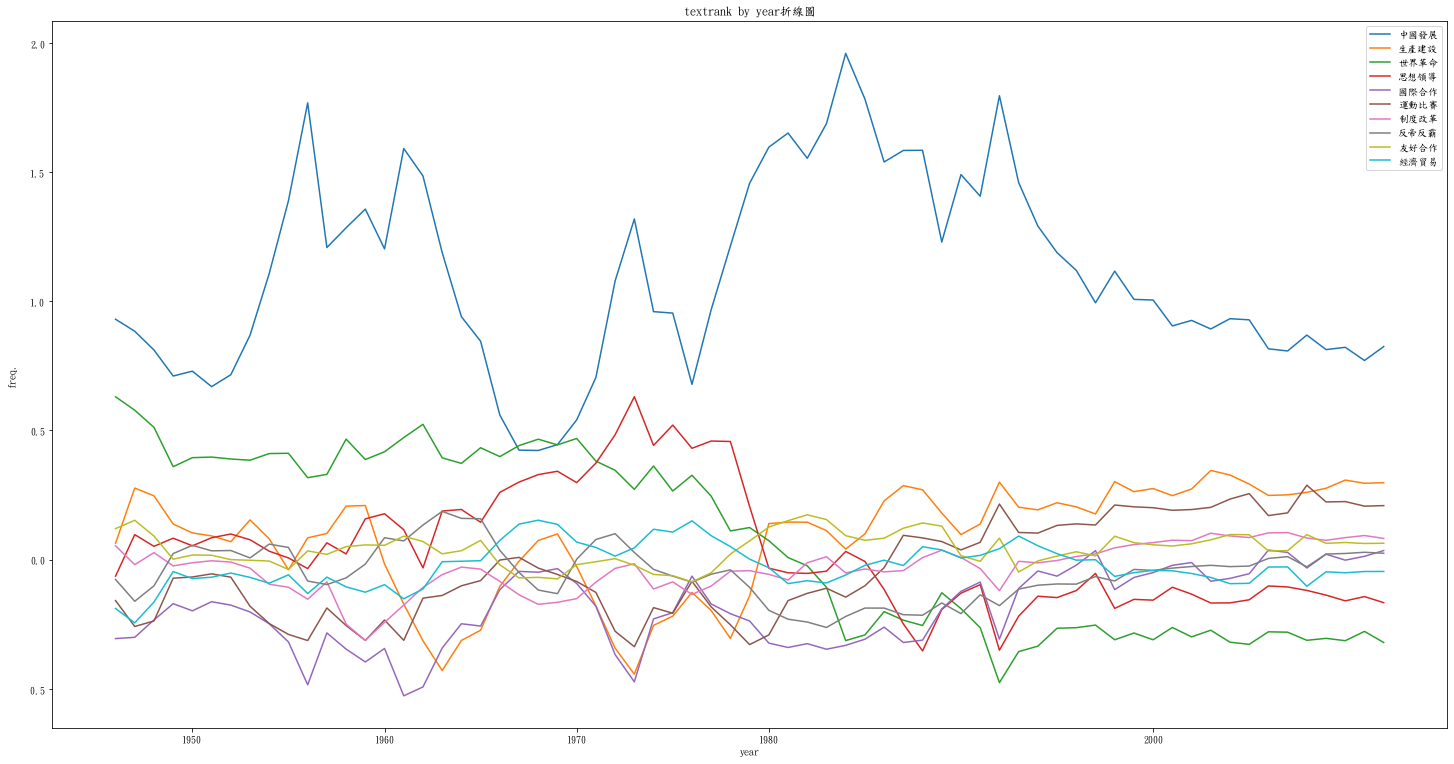

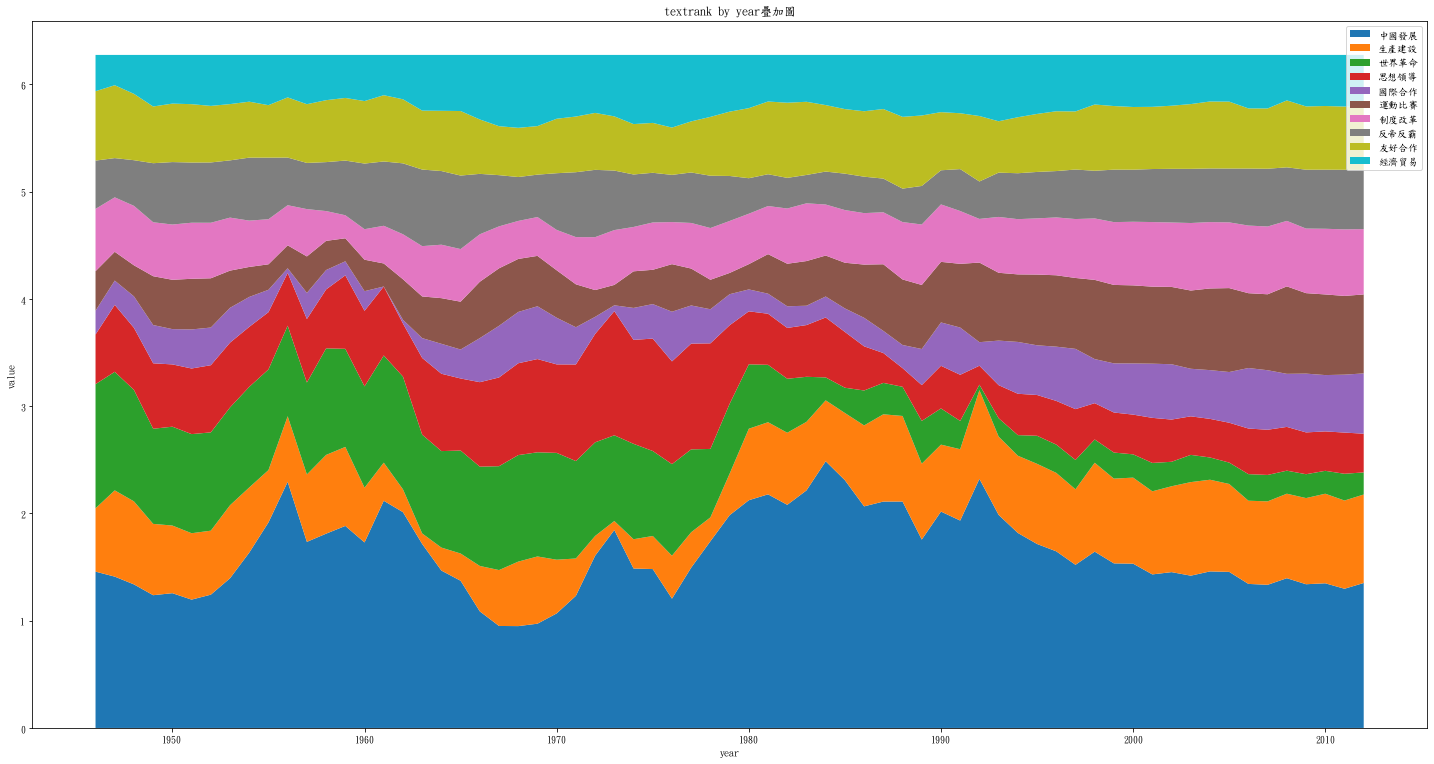

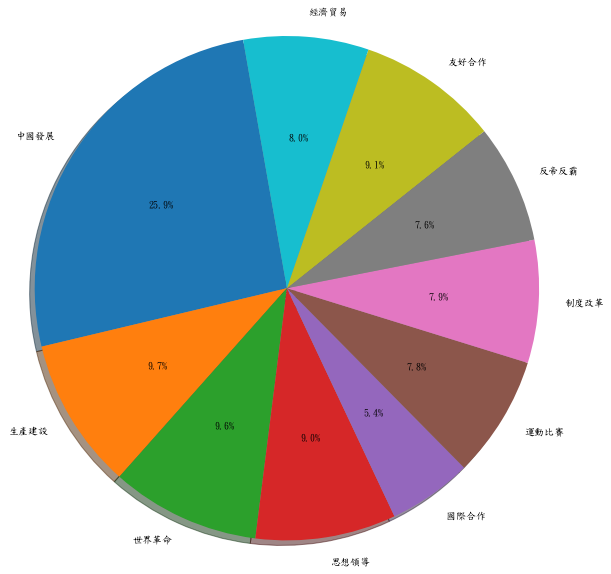

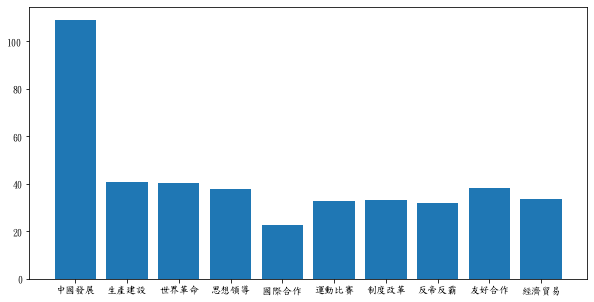

In [61]:
topic=""
(df_ts, totals,size)=plot_topic_model_year(path, df_lsa,topics, num_i,title)

# 加入 people 模組

In [13]:
import people

## 讀取 所有文章的 textrank

In [14]:
# 讀取檔案 #######################################
import pandas as pd
# 必須要有的參數
unit="arti"
field="textrank"
path="D:/my python/people/" 
title="all"
filename=path+"working/"+unit+"_"+field+"_"+title+".pkl"
df=people.read_pkl_file( filename, path)
df

,year,filename,title,textrank
0,1946,人民日報_19460515_2_1941,群众认为物资微少，不足弥补八年创伤联总救济物资一部先后运到我区发放,"救济,滑县,分署,河南,面粉,豫北,衣物,发放,物资,种子,农村,灾区,生产,作风,药品,工..."
1,1946,人民日報_19460515_2_1942,生动真实深受欢迎演出“两种作风”军区文工团,"吸收,纵队,改进,集体创作,部队,报上,张际春,整训,文艺,工作团,军区,秧歌,广场,执笔,..."
2,1946,人民日報_19460515_2_1943,野战兵团在绥蒙区垦荒晋绥各部队紧张生产,"生产,群众,驻军,连队,自给,生产队,部队,驻地,开荒,兵团,组织,文水,水地,紧张,野战,..."
3,1946,人民日報_19460515_2_1945,人民日报发刊志祝,"事业,原子弹,读者,拥护者,斗争,反法西斯,虔诚,杨秀峰,预祝,胜利,边区,司机,组织者"
4,1946,人民日報_19460515_3_1959,英勇的四平街保卫战,"四平,民主,炮火,联军,阵地,战士,老百姓,东北,政府,俘虏,和平,反动派,同志,战争,士兵..."
...,...,...,...,...
1586633,2012,人民日報_20120101_2_20645,全国人大常委会办公厅举行新闻发布会,"职业病,澳门,诊断,防治法,鉴定,修改,政治体制,救治,安监,总局,全国人大常委会,病人,全..."
1586634,2012,人民日報_20120101_3_20646,人大常委会第二十四次会议在京闭幕,"会议,发展,全国人大常委会,全国人大,审议,草案,表决,经济,吴邦国,职业病,教育,保障,农..."
1586635,2012,人民日報_20120101_3_20647,迎希望 鼓信心,"国家,南非,成功,经济,转型,致辞,政府,社会,欧元,总理,马来西亚,总统,政治,骄傲,快乐..."
1586636,2012,人民日報_20120101_3_20648,朝鲜发布迎接金日成诞辰100周年联合口号,"全党,全军,全民,金正恩,国家,朝鲜劳动党,政治,诞辰,口号,号召,领导,金正日,军队,朝鲜..."


In [15]:
method="nmf"  # svd,lda, nmf 三選一
path="D:/my python/people/" 
num_i=10
field="textrank"
title=""
doc_list=df.textrank
(df_topic, df, df_lsa)= people.topic_model(df,field,num_i, method)  

tfidf......
extract topics ......


C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


維度數 10
字詞數 1369411
0 ['社会', '建设', '改革', '完善', '管理', '制度', '实施', '部门', '发展', '机制', '保障', '经济', '加大', '增强', '国务院', '政府', '提高', '服务', '力度', '创新', '稳定', '法律', '协调', '解决', '环境', '中央', '体系', '目标', '规范', '科学']
1 ['合作', '两国', '关系', '会见', '发展', '友好合作', '中国', '两国人民', '领域', '经济', '友好', '交流', '友谊', '中国政府', '访问', '友好关系', '总理', '领导人', '增进', '国际', '稳定', '建交', '交往', '总统', '和平', '交换', '双边关系', '人民大会堂', '互利', '赞赏']
2 ['斗争', '侵略', '美帝国主义', '帝国主义', '民族', '战争', '全世界', '胜利', '越南', '独立', '阴谋', '支持', '和平', '团结', '敌人', '谴责', '保卫', '解放', '侵略者', '战斗', '力量', '民主', '美国', '集团', '自由', '世界', '英勇', '走狗', '正义斗争', '亚洲']
3 ['代表团', '率领', '北京', '访问', '团长', '乘飞机', '大使', '机场', '中国', '到达', '邀请', '离开', '今天下午', '友好访问', '友好', '会见', '负责人', '回国', '今天上午', '夫人', '出席', '谈话', '部长', '参观', '送行', '大使馆', '宴会', '在座', '副部长', '迎接']
4 ['企业', '产品', '公司', '市场', '生产', '工业', '技术', '投资', '增长', '经济', '设备', '出口', '国家', '发展', '开发', '项目', '提高', '经营', '资金', '计划', '先进', '行业', '国际', '质量', '职工', '全国', '价格', '规模', '销售', '工厂']
5 ['文化', '中国', '举办', '北京', '艺术'

## plot_topic_model_trend(df_lsa,topics, num_i) 

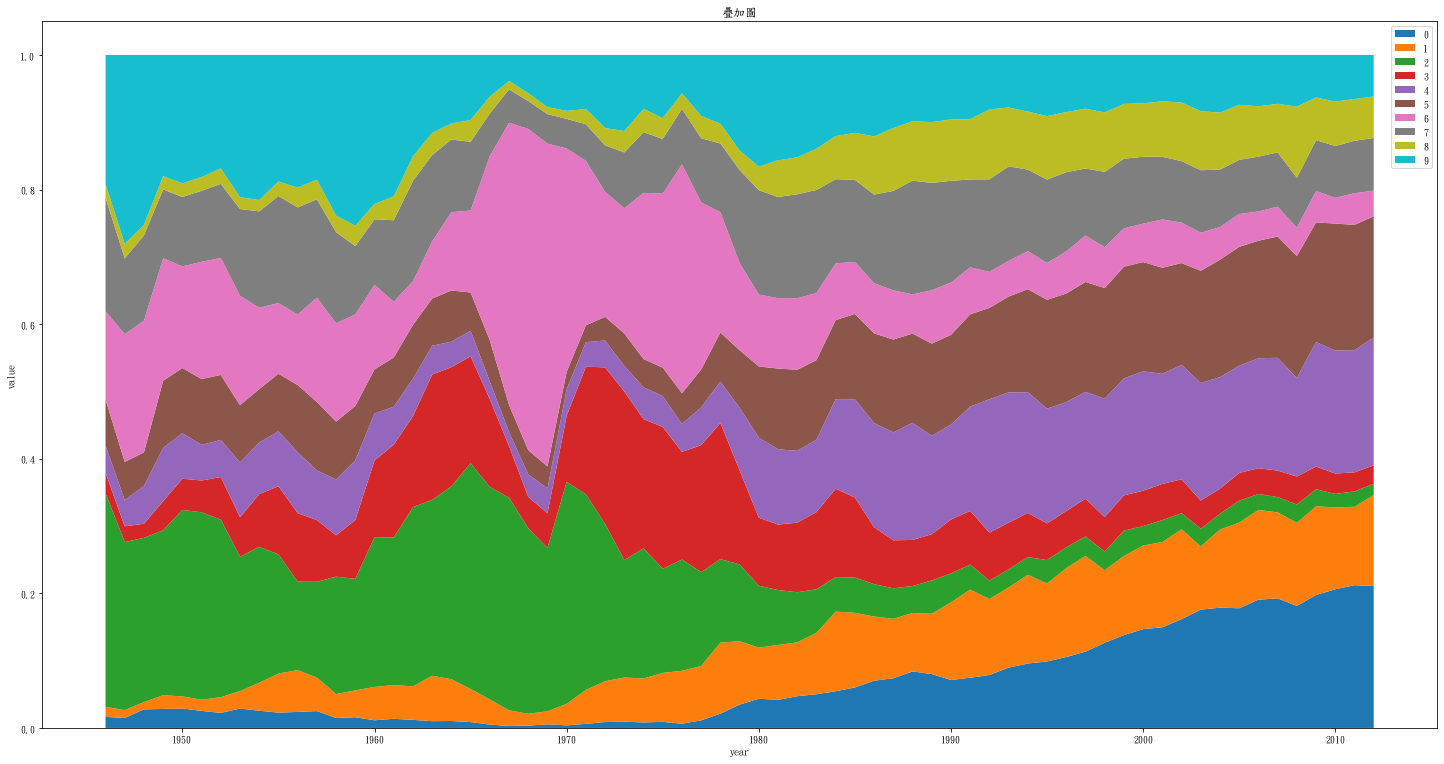

NameError: name 'num_i' is not defined

In [16]:
topic="textrank"
year=df_lsa.year.unique()
num_i=len(df_lsa.columns)-1
topics=range(num_i)
ts= people.plot_topic_model_trend(df_lsa,topics, 10) 

In [ ]:
len(df_lsa.columns)